In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, isnan, count
from src.utils.s3_manager import S3Manager
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import os

nltk_data_dir = 'nltk_data'

if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)
  
nltk.data.path.append(nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This is a simple EDA to have a better understanding of the data.
We will use Spark for loading the data and Pandas for visualization and plots

In [8]:

data_dir = "/Users/ilan/big-data-airflow-project/data"

In [9]:
spark = SparkSession.builder \
    .appName("EDA with Spark") \
    .getOrCreate()

In [10]:
df = spark.read.parquet(data_dir+"/netflix_dataset.parquet", header=True, inferSchema=True)

In [11]:
df.show()

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|            director|                cast|             country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                NULL|       United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|                NULL|Ama Qamata, Khosi...|        South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglan

In [12]:
df.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)


In [13]:
print("The shape of the netflix dataset is ", (df.count(), len(df.columns)))

The shape of the netflix dataset is  (8809, 12)


In [14]:
df.describe().show()

24/05/17 09:02:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|summary|             show_id|         type|                            title|            director|                cast|         country|     date_added|     release_year|           rating|     duration|           listed_in|         description|
+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|  count|                8809|         8808|                             8807|                6173|                7983|            7977|           8796|             8807|             8803|         8804|                8806|                8806|
|   mean|       

# Dealing with missing values

We will look at each column to see how to manage missing values

In [15]:
missing_values = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_values.show()

+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   1|    2|    2636| 826|    832|        13|           2|     6|       5|        3|          3|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+


#### Director, cast and date_added columns

We will drop the director column, the cast and the date_added. These columns contain too much NaN values, and we cannot replace them. 
It will be easier to drop them.

In [16]:
df = df.drop("cast", "director", "date_added")

#### Country column

In [17]:
value_counts_df = df.groupBy("country").count().orderBy("count", ascending=False).show()


+--------------------+-----+
|             country|count|
+--------------------+-----+
|       United States| 2805|
|               India|  972|
|                NULL|  832|
|      United Kingdom|  419|
|               Japan|  245|
|         South Korea|  199|
|              Canada|  181|
|               Spain|  145|
|              France|  123|
|              Mexico|  110|
|               Egypt|  106|
|              Turkey|  105|
|             Nigeria|   93|
|           Australia|   87|
|              Taiwan|   81|
|           Indonesia|   79|
|              Brazil|   77|
|United Kingdom, U...|   75|
|         Philippines|   75|
|United States, Ca...|   73|
+--------------------+-----+


Let's replace all missing countries by United States

In [18]:
df = df.fillna({'country': 'United States'})

#### Rating column

In [19]:
df.groupBy("rating").count().orderBy("count", ascending=False).show()


+-----------------+-----+
|           rating|count|
+-----------------+-----+
|            TV-MA| 3195|
|            TV-14| 2158|
|            TV-PG|  862|
|                R|  796|
|            PG-13|  489|
|            TV-Y7|  334|
|             TV-Y|  307|
|               PG|  286|
|             TV-G|  220|
|               NR|   80|
|                G|   41|
|             NULL|    6|
|         TV-Y7-FV|    6|
|               UR|    3|
|            NC-17|    3|
|             2021|    2|
| November 1, 2020|    1|
| Shavidee Trotter|    1|
|    Adriane Lenox|    1|
|    Maury Chaykin|    1|
+-----------------+-----+


In [20]:
df = df.fillna({'rating': 'TV-MA'})

#### Type column

In [21]:
df.groupBy("type").count().orderBy("count", ascending=False).show()


+-------------+-----+
|         type|count|
+-------------+-----+
|        Movie| 6131|
|      TV Show| 2676|
|         NULL|    1|
|William Wyler|    1|
+-------------+-----+


In [22]:
df = df.fillna({'type': 'Movie'})

#### Duration, listed_in, description, title columns

In [23]:
df = df.dropna()

In [27]:
bool(df.filter(df.title.contains("Forest Gump")).collect())

False

## Plots

In [102]:
pandas_df = df.toPandas() 

/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_94864/2404073007.py:1 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

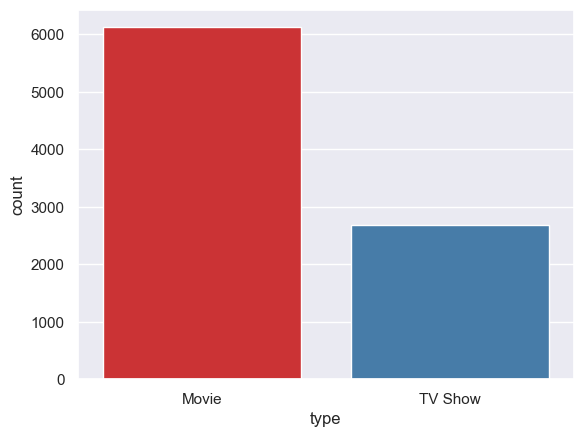

In [103]:
ax = sns.countplot(x="type", data=pandas_df, palette="Set1")

### Rating distribution

/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_94864/1687379873.py:2 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

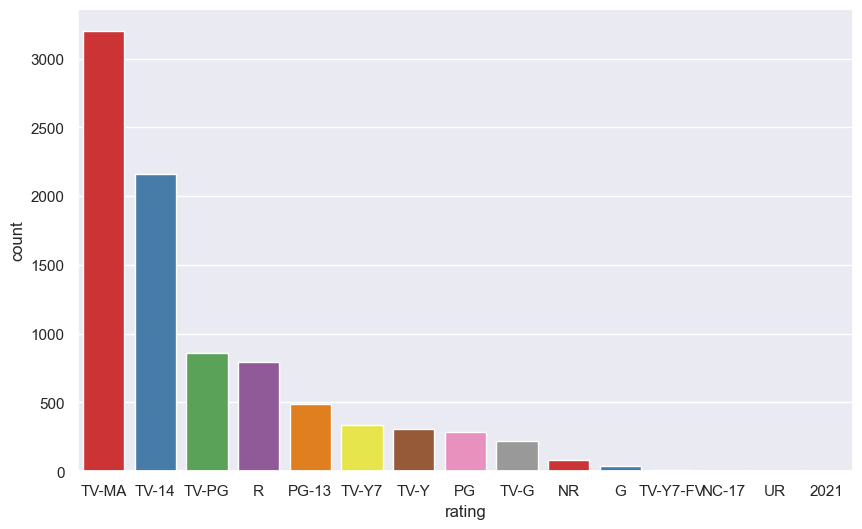

In [104]:
plt.figure(figsize=(10,6))
sns.countplot(x="rating", legend=False,data=pandas_df, palette="Set1",  order=pandas_df['rating'].value_counts().index[0:15])
plt.show()

### Released year

[2024-05-17T00:26:32.525+0200] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_94864/1959414778.py:3 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

[2024-05-17T00:26:32.563+0200] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


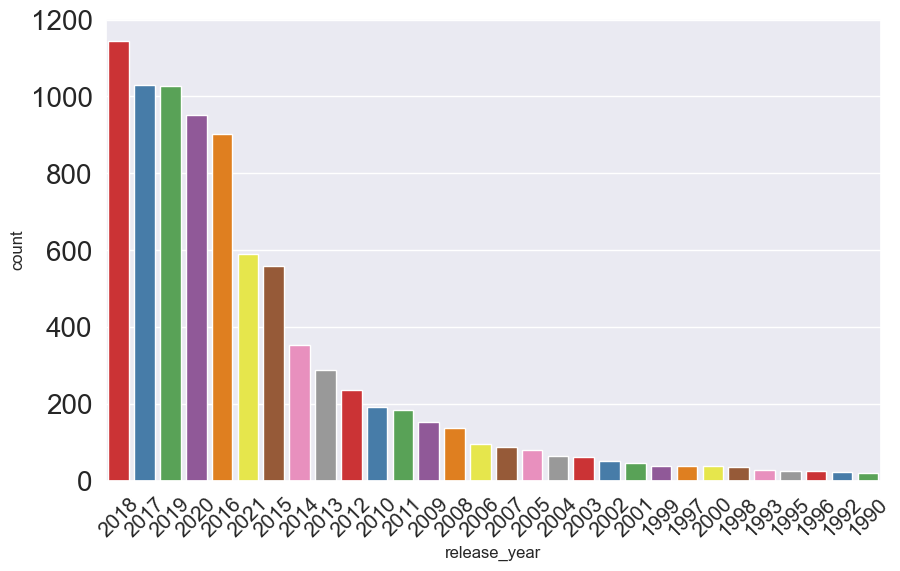

In [105]:
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(x=pandas_df["release_year"], order = pandas_df['release_year'].value_counts().index[0:30], palette="Set1")
plt.xticks(rotation=45,fontsize = 15)
plt.yticks(fontsize = 20)
plt.show()

## EDA NLP

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


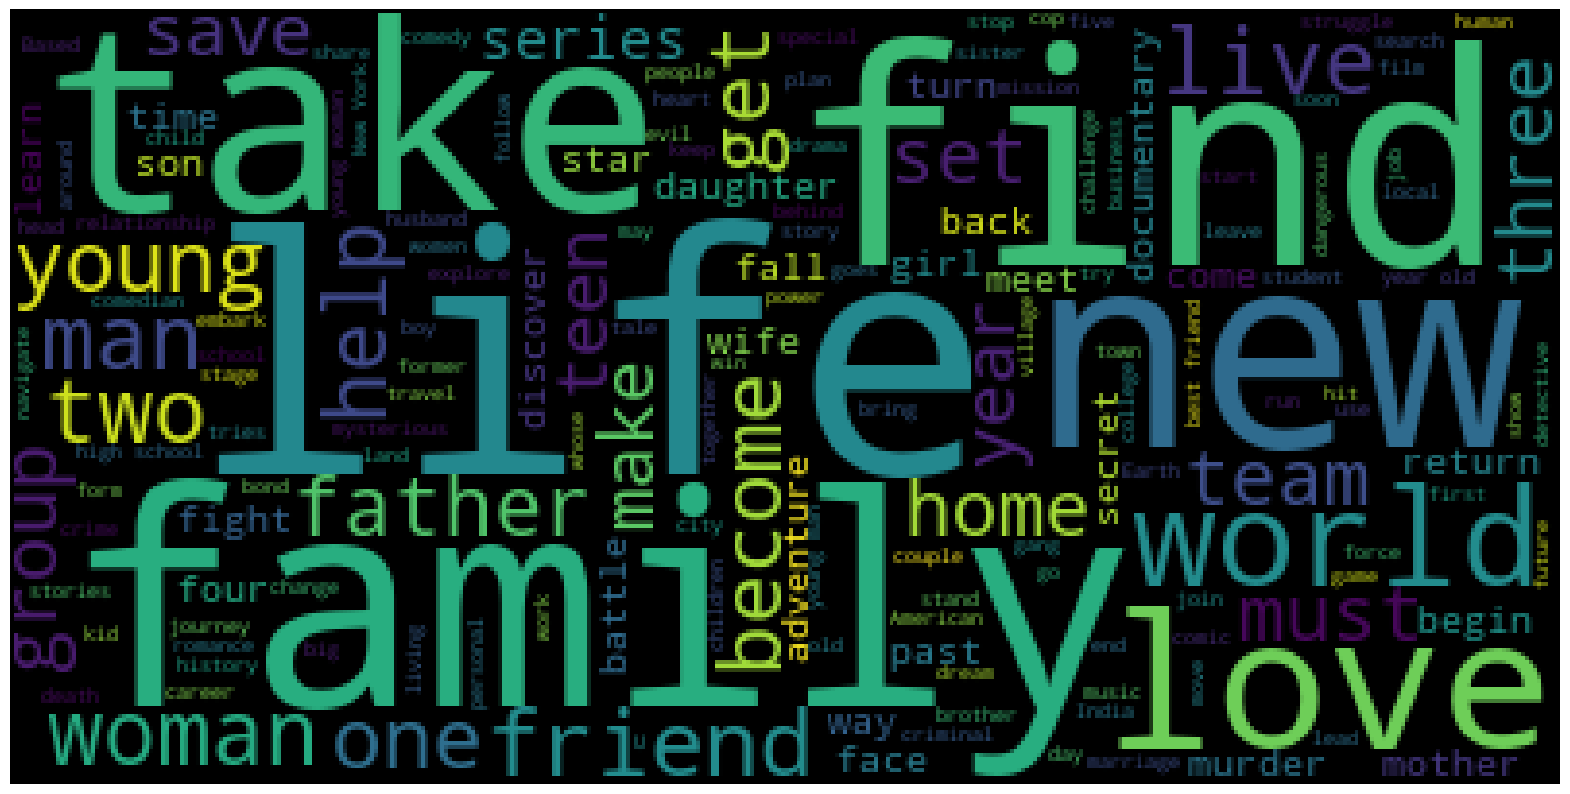

In [109]:
stop_words = set(stopwords.words('english'))
plt.figure(figsize=(20,20))
wordcloud = WordCloud(background_color = 'black', stopwords = stop_words).generate(" ".join(pandas_df.description))

plt.imshow(wordcloud)
plt.axis("off")
plt.show();